<a href="https://colab.research.google.com/github/Denis-R-V/TSR/blob/main/sign_detector_augmentated_v1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Denis-R-V/TSR/blob/main/sign_detector.ipynb)

# Система распознавания дорожных знаков на датасете RTSD

In [95]:
colab = False

if colab == True:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install kaggle
    !mkdir ~/.kaggle
    !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
    !kaggle datasets download watchman/rtsd-dataset
    !unzip rtsd-dataset.zip
    !rm rtsd-dataset.zip
    !cp -r rtsd-frames/rtsd-frames/ .
    !rm -r rtsd-frames/rtsd-frames/
    !pip install fiftyone
if colab == True:
    dataset_path = '.'
    checkpoints_path = '../content/drive/MyDrive/TSR/checkpoints'
else:
    dataset_path = 'data'
    checkpoints_path = 'checkpoints'

import os
import json
import numpy as np 
import pandas as pd 

from PIL import Image
import matplotlib.pyplot as plt
#import matplotlib.patches as patches
#%matplotlib inline

#from pycocotools.coco import COCO
#import fiftyone as fo
import time
import torch
import torch.nn as nn
#import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
#from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#from torchvision.models.detection import FasterRCNN
from torchvision import models
from torchvision.models import resnet152
#import cv2
#PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0

## Обучение модели

### Загрузчик данных

In [119]:
class RTSD_dataset_classifier(Dataset):
    def __init__(self, dataset_path, background_anno_file, dataset_anno_file, transforms):
        
        self.dataset_path = dataset_path
        self.background_anno_file = background_anno_file
        self.dataset_anno_file = dataset_anno_file
        self.transforms = transforms
        
        with open(os.path.join(dataset_path, background_anno_file), 'r') as read_file:
            self.background_anno = json.load(read_file)
        read_file.close()

        #self.df_backgrnd_anno = pd.DataFrame(self.background_anno.get('annotations'))[['image_id','bbox','category_id']]
        #self.df_backgrnd_images = pd.DataFrame(self.background_anno.get('images'))[['id','file_name']]
        #self.df_backgrnd = self.df_backgrnd_anno.merge(self.df_backgrnd_images, left_on='image_id', right_on='id',)[['file_name','bbox','category_id']]
        df_backgrnd_anno = pd.DataFrame(self.background_anno.get('annotations'))[['image_id','bbox','category_id']]
        df_backgrnd_images = pd.DataFrame(self.background_anno.get('images'))[['id','file_name']]
        df_backgrnd = df_backgrnd_anno.merge(df_backgrnd_images, left_on='image_id', right_on='id',)[['file_name','bbox','category_id']]

        with open(os.path.join(dataset_path, dataset_anno_file), 'r') as read_file:
            self.anno = json.load(read_file)
        read_file.close()

        #self.df_anno = pd.DataFrame(self.anno.get('annotations'))[['image_id','bbox','category_id']]
        #self.df_images = pd.DataFrame(self.anno.get('images'))[['id','file_name']]
        #self.df_dataset = self.df_anno.merge(self.df_images, left_on='image_id', right_on='id',)[['file_name','bbox','category_id']]

        df_anno = pd.DataFrame(self.anno.get('annotations'))[['image_id','bbox','category_id']]
        df_images = pd.DataFrame(self.anno.get('images'))[['id','file_name']]
        self.df_dataset = df_anno.merge(df_images, left_on='image_id', right_on='id',)[['file_name','bbox','category_id']]
        
        self.df_dataset = pd.concat((df_backgrnd, self.df_dataset), axis=0)
        self.df_dataset.reset_index(inplace=True)
        del self.df_dataset['index']    
        #self.labels = torch.eye(156)[self.df_dataset['category_id']]'''

    def __len__(self):
        return self.df_dataset.shape[0]

    def __getitem__(self, index):
        img_name = self.df_dataset.loc[index,'file_name']
        bbox = self.df_dataset.loc[index,'bbox']
        bbox = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]
        img = Image.open(os.path.join(self.dataset_path, img_name))
        img = img.crop(bbox)
        img = self.transforms(img)
        label = torch.tensor(self.df_dataset.loc[index,'category_id'])
        

        #from PIL import ImageOps
        #old_img = Image.open(image_path)
        # создание нового изображения с белым фоном
        #new_image = ImageOps.expand(old_img, border=25, fill=(255,255,255))

        return {'images':img, 'labels':label}



In [109]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
def get_transform(train=False):
    if train==True:
        return A.Compose([A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.8),
                          A.RandomFog(fog_coef_lower=0.2, fog_coef_upper=0.3, alpha_coef=0.1, p=0.05), #Туман
                          A.RandomRain(brightness_coefficient=0.9, drop_width=1, blur_value=5, p=0.05),
                          A.Rotate(limit=10, p=0.5),
                          #A.RandomShadow(num_shadows_lower=1, num_shadows_upper=1, shadow_dimension=5, shadow_roi=(0, 0.5, 1, 1), p=1),
                          #A.RandomSnow(brightness_coeff=1.5, snow_point_lower=0.3, snow_point_upper=0.5, p=1),
                          #A.RandomSunFlare(flare_roi=(0, 0, 1, 0.5), angle_lower=0.5, p=1),
                          # ToTensorV2 converts image to pytorch tensor without div by 255
                          ToTensorV2(p=1.0)
                          ])
        
    else:
        return A.Compose([ToTensorV2(p=1.0)])

In [121]:
def get_transform(train):
    if train == True:
        return transforms.Compose([transforms.Resize((224,224)),
                                   transforms.RandomPerspective(distortion_scale=0.4, p=0.2),
                                   transforms.ToTensor(),
                                   transforms.ColorJitter(brightness=(0.5), contrast=(0.4), saturation=(0.4)),
                                   transforms.GaussianBlur(11, sigma=(0.1, 2.0)),
                                   #transforms.GaussianBlur((7, 13), sigma=(2, 7)),
                                   #transforms.RandomAdjustSharpness(5),
                                   #transforms.RandomRotation(10),
                                   #transforms.RandomResizedCrop((224,224), scale=(0.85, 1)), # Случайная обрезка изображения в диапахоне 85 - 100% и resize в исходный размер
                                   #transforms.Normalize([0.485, 0.456, 0.406],      # 1 496
                                   #                     [0.229, 0.224, 0.225]),
                                   transforms.RandomErasing(p = 0.4, scale = (0.003, 0.1)),
                                   transforms.RandomErasing(p = 0.6, scale = (0.003, 0.05)),
                                   transforms.RandomErasing(p = 0.6, scale = (0.003, 0.05)),
                                   transforms.RandomErasing(p = 0.6, scale = (0.003, 0.02)),
                                   transforms.RandomErasing(p = 0.6, scale = (0.003, 0.02)),
                                   transforms.RandomErasing(p = 0.6, scale = (0.001, 0.01)),
                                   transforms.RandomErasing(p = 0.6, scale = (0.001, 0.01)),
                                   transforms.RandomErasing(p = 0.6, scale = (0.001, 0.01)),
                                   transforms.RandomErasing(p = 0.6, scale = (0.001, 0.01)),
                                   transforms.RandomErasing(p = 0.6, scale = (0.001, 0.01)),
                                   ])
    else:
        return transforms.Compose([transforms.Resize((224,224)),
                                   transforms.ToTensor(),
                                   #transforms.Normalize([0.485, 0.456, 0.406],      # 1 496
                                   #                     [0.229, 0.224, 0.225])
                                   ])

In [122]:
test = RTSD_dataset_classifier(dataset_path,
                               background_anno_file = 'train_anno_reduced_background.json',
                               dataset_anno_file = 'train_anno_reduced.json',
                               transforms = get_transform(train=True)
                               )

In [779]:
#test.__getitem__(13)

1

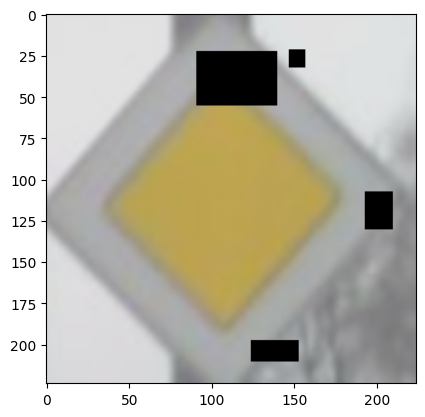

In [125]:
def plot_sign(dataset, index):
    item = dataset.__getitem__(index)
    img = item['images']
    target = item['labels']
    #img, target = test.__getitem__(index)
    img = img.permute(1, 2, 0).detach().numpy()
    img = img*255
    img = img.astype(np.uint8)
    fig, a = plt.subplots(1,1)
    #fig.set_size_inches(10,10)
    display(int(target.cpu().detach().numpy()))
    a.imshow(img)
    return None
plot_sign(test, 904)

### Гиперпараметры

In [126]:
device_id = 0
if torch.cuda.is_available() == True:
    device = f'cuda:{device_id}'
elif torch.backends.mps.is_available() == True:
    device = 'mps'
else:
    device = 'cpu'

model_name = 'resnet152_augmented_tvs_medium'
last_epoch = None
n_epochs = 20
batch_size = 32
num_classes = 156

device

'cuda:0'

### Инициализация модели, задание оптимизатора и функции потерь

In [128]:
def create_model(num_classes):
    model = resnet152(weights='ResNet152_Weights.IMAGENET1K_V2')
    #model = models.resnext101_32x8d(pretrained=True)
    #model = models.alexnet(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    #model.fc = nn.Linear(4096, num_classes)
    
    #model.fc = nn.Sequential(nn.Linear(2048, 1024), nn.Linear(1024, num_classes))
    for param in model.fc.parameters():
        param.requires_grad = True

    #torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.COCO_V1')
    #in_features = model.roi_heads.box_predictor.cls_score.in_features
    #model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [13]:
checkpoint = torch.load(os.path.join(checkpoints_path, f'chkpt_classifier_{model_name}_{last_epoch}.pth'), map_location=device)

In [15]:
checkpoint.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'losses_train', 'losses_val'])

In [129]:
model = create_model(num_classes).to(device)

loss_function = nn.CrossEntropyLoss()

# parameters
params = [p for p in model.parameters() if p.requires_grad]
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
#params = [p for p in model.parameters() if p.requires_grad]

#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

#optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

# Загрузка весов модели, состояния оптимизатора и шедулера
if last_epoch is not None:
    checkpoint = torch.load(os.path.join(checkpoints_path, f'chkpt_classifier_{model_name}_{last_epoch}.pth'), map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])


train_dataset = RTSD_dataset_classifier(dataset_path,
                                        background_anno_file = 'train_anno_reduced_background.json',
                                        dataset_anno_file = 'train_anno.json',
                                        transforms = get_transform(train=True)
                                        )

val_dataset = RTSD_dataset_classifier(dataset_path,
                                      background_anno_file = 'val_anno_background.json',
                                      dataset_anno_file = 'val_anno.json',
                                      transforms = get_transform(train=False)
                                      )

train_data_loader = DataLoader(
    train_dataset,
    #sampler=SubsetRandomSampler(),
    batch_size=batch_size,
    shuffle=True,
    #num_workers=4,
    #collate_fn=collate_fn
)

val_data_loader = DataLoader(
    val_dataset,
    #sampler=SubsetRandomSampler(),
    batch_size=batch_size,
    shuffle=False,
    #num_workers=4,
    #collate_fn=collate_fn
)

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to C:\Users\User/.cache\torch\hub\checkpoints\resnet152-f82ba261.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

### Трейн луп

In [131]:
def train(train_dataloader, epoch): 
    len_dataloader = len(train_dataloader)

    training_loss=0
    correct = 0.0
    total = 0.0

    model.train()
    running_loss = 0        # training_loss
    for batch_idx, data in enumerate(train_dataloader):
        
        
        
        optimizer.zero_grad()
        #images, targets = data[0], data[1]
        #images = images.to(device)
        #targets = targets.to(device)
        images = data['images'].to(device)
        targets = data['labels'].to(device)
        output = model(images)
        loss = loss_function(output, targets)
        loss.backward()
        optimizer.step()
        
        running_loss = running_loss + ((1/(batch_idx+1))*(loss.data-running_loss))
        if batch_idx%20 == 0:
            print(f"Batch Id {batch_idx} is having training loss of {running_loss}")
            print(loss.item())

        pred = output.data.max(1,keepdim=True)[1]
        correct += np.sum(np.squeeze(pred.eq(targets.data.view_as(pred))).cpu().numpy())
        total += images.size(0)
        train_accuracy = 100*correct/total
        print(f"Accuracy on batch {batch_idx} on Training is {(100*correct/total)}")


        #images = list(image.to(device) for image in images)
        #targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        #loss_dict = model(images, targets)
        #loss = sum(loss for loss in loss_dict.values())
        #running_loss += loss.item()
        #loss.backward()
        #optimizer.step()
        #if batch_idx % 50 == 0:
        #    print(f"\tЭпоха {epoch}. Итерация {batch_idx}/{len_dataloader}. Loss: {loss}")
    train_loss = running_loss/len(train_dataloader.dataset)
    return train_loss, train_accuracy

In [132]:
def val (val_dataloader, epoch):
    #len_dataloader = len(train_dataloader)

    validation_loss=0
    correct = 0.0
    total = 0.0

    model.eval()

    for batch_idx, data in enumerate(val_dataloader):
        
        
        optimizer.zero_grad()
        #images, targets = data[0], data[1]
        #images = images.to(device)
        #targets = targets.to(device)
        images = data['images'].to(device)
        targets = data['labels'].to(device)
        #with torch.no_grad():
            
        output = model(images)
        loss = loss_function(output, targets)
        
        validation_loss = validation_loss + ((1/(batch_idx+1))*(loss.data-validation_loss))
        #if batch_idx%20 == 0:
        print(f"Batch Id {batch_idx} is having validation loss of {validation_loss}")
        print(loss.item())

        pred = output.data.max(1,keepdim=True)[1]
        correct += np.sum(np.squeeze(pred.eq(targets.data.view_as(pred))).cpu().numpy())
        total += images.size(0)
        val_accuracy = 100*correct/total
        print(f"Batch Id {batch_idx} is having validation accuracy of {(100*correct/total)}")


        #images = list(image.to(device) for image in images)
        #targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        #loss_dict = model(images, targets)
        #loss = sum(loss for loss in loss_dict.values())
        #running_loss += loss.item()
        #loss.backward()
        #optimizer.step()
        #if batch_idx % 50 == 0:
        #    print(f"\tЭпоха {epoch}. Итерация {batch_idx}/{len_dataloader}. Loss: {loss}")
    val_loss = validation_loss/len(val_dataloader.dataset)
    return val_loss, val_accuracy

In [133]:
# Загрузка словарей с лоссами
if last_epoch is not None:
    train_losses = checkpoint['losses_train']
    val_losses = checkpoint['losses_val']
else:
    train_losses = []
    val_losses = []

if last_epoch is None:
    start_epoch = 0
else:
    start_epoch = last_epoch +1

try:
    for epoch in range(start_epoch, n_epochs):
        start = time.time()
        train_loss, train_accuracy = train(train_data_loader, epoch)
        val_loss, val_accuracy = val(val_data_loader, epoch)
        lr_scheduler.step()
        print(f"Эпоха #{epoch} train_loss: {train_loss}, val_loss: {val_loss}")  
        end = time.time()
        print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        torch.save({'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'lr_scheduler_state_dict': lr_scheduler.state_dict(),
                    'losses_train': train_losses,
                    'losses_val': val_losses,
                    'accuracy_train': train_accuracy,
                    'accuracy_val': val_accuracy,
                    }, os.path.join(checkpoints_path, f'chkpt_classifier_{model_name}_{epoch}.pth'))
    
        torch.save(model, os.path.join(checkpoints_path, f'model_classifier_{model_name}_{epoch}.pth'))
    
except KeyboardInterrupt:
    print('Прервано пользователем')

Batch Id 0 is having training loss of 5.111151218414307
5.111151218414307
Accuracy on batch 0 on Training is 0.0
Accuracy on batch 1 on Training is 1.5625
Accuracy on batch 2 on Training is 1.0416666666666667
Accuracy on batch 3 on Training is 3.125
Accuracy on batch 4 on Training is 6.25
Accuracy on batch 5 on Training is 8.333333333333334
Accuracy on batch 6 on Training is 9.821428571428571
Accuracy on batch 7 on Training is 11.328125
Accuracy on batch 8 on Training is 12.847222222222221
Accuracy on batch 9 on Training is 13.4375
Accuracy on batch 10 on Training is 13.920454545454545
Accuracy on batch 11 on Training is 15.104166666666666
Accuracy on batch 12 on Training is 14.663461538461538
Accuracy on batch 13 on Training is 15.848214285714286
Accuracy on batch 14 on Training is 16.666666666666668
Accuracy on batch 15 on Training is 17.578125
Accuracy on batch 16 on Training is 17.647058823529413
Accuracy on batch 17 on Training is 17.708333333333332
Accuracy on batch 18 on Trainin

In [35]:
item = 13
model.eval()
pred = model(val_dataset.__getitem__(item)['images'].unsqueeze(0).to(device)).data.max(1,keepdim=True)[1], 
int(pred[0][0][0]), int(val_dataset.__getitem__(item)['labels'])

(71, 72)

In [21]:
last_epoch = 2
# Загрузка весов модели
checkpoint = torch.load(os.path.join(checkpoints_path, f'model_detector_resnet50_augmented_{last_epoch}.pth'), map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])
#epoch = checkpoint['epoch']
train_losses = checkpoint['losses_train']
val_losses = checkpoint['losses_val']

In [27]:
last_epoch = 3
model_name = 'detector_resnet50_augmented'


if last_epoch == None:
    train_losses = []
    val_losses = []
else:
    # Загрузка весов модели
    checkpoint = torch.load(os.path.join(checkpoints_path, f'chkpt_{model_name}_{last_epoch}.pth'), map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])
    #epoch = checkpoint['epoch']
    train_losses = checkpoint['losses_train']
    val_losses = checkpoint['losses_val']

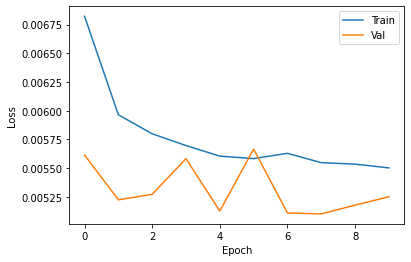

In [30]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(train_losses, label='Train')
ax.plot(val_losses, label='Val')
#ax.plot(val_losses, label='Val')
ax.set(xlabel='Epoch', ylabel='Loss')
ax.legend()
plt.show()